<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/23_1_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. Анализ временных рядов
2. [Сравнение архитектур нейронных сетей для обработки временных рядов](https://colab.research.google.com/drive/1-D-qXFYJ9b5sLLz_CFkUYmR-I2tM7KO2)
3. [Домашняя работа](https://colab.research.google.com/drive/181g4qP5fB9PsqGCkcKAR37btxpRMU1Zt)

**В данном уроке мы изучим:**
1. Что такое временные ряды?
2. На какие компоненты можно разделить временной ряд?
3. Узнаем, что такое корреляция и автокорреляция.
4. Научимся исключать тренд из временного ряда.

**В практической части урока:**
1. Познакомимся с генератором временных рядов.
2. Научимся строить различные архитектуры НС для анализа временных рядов.
3. Сравним архитектуры.

## Анализ временных рядов

### Основные понятия

> **Временной ряд (time series)** — это данные, последовательно собранные в регулярные промежутки времени.

> К таким данным относятся, например, цены на акции, объемы продаж, изменения температуры с течением времени и многое другое. Посмотрим на изменение обычных данных и временных рядов.

**Работа с временными рядами предполагает два аспекта:**

1. Анализ временного ряда (time series analysis), т.е. понимание его структуры и закономерностей.
2. Моделирование и построение прогноза на будущее (time series forecasting).

**Договоримся о терминах:**

* Определим нотацию периодов. Временем $t$ обозначим настоящее, $t−1, t−2,… $ - прошлое, $t+1, t+2,…$ - будущее.
* Введем понятие временного лага ($lag$), т.е. запаздывание по сравнению с заданным периодом: $lag 1 = t - 1$, соответственно, $lag 3 = t - 3$.

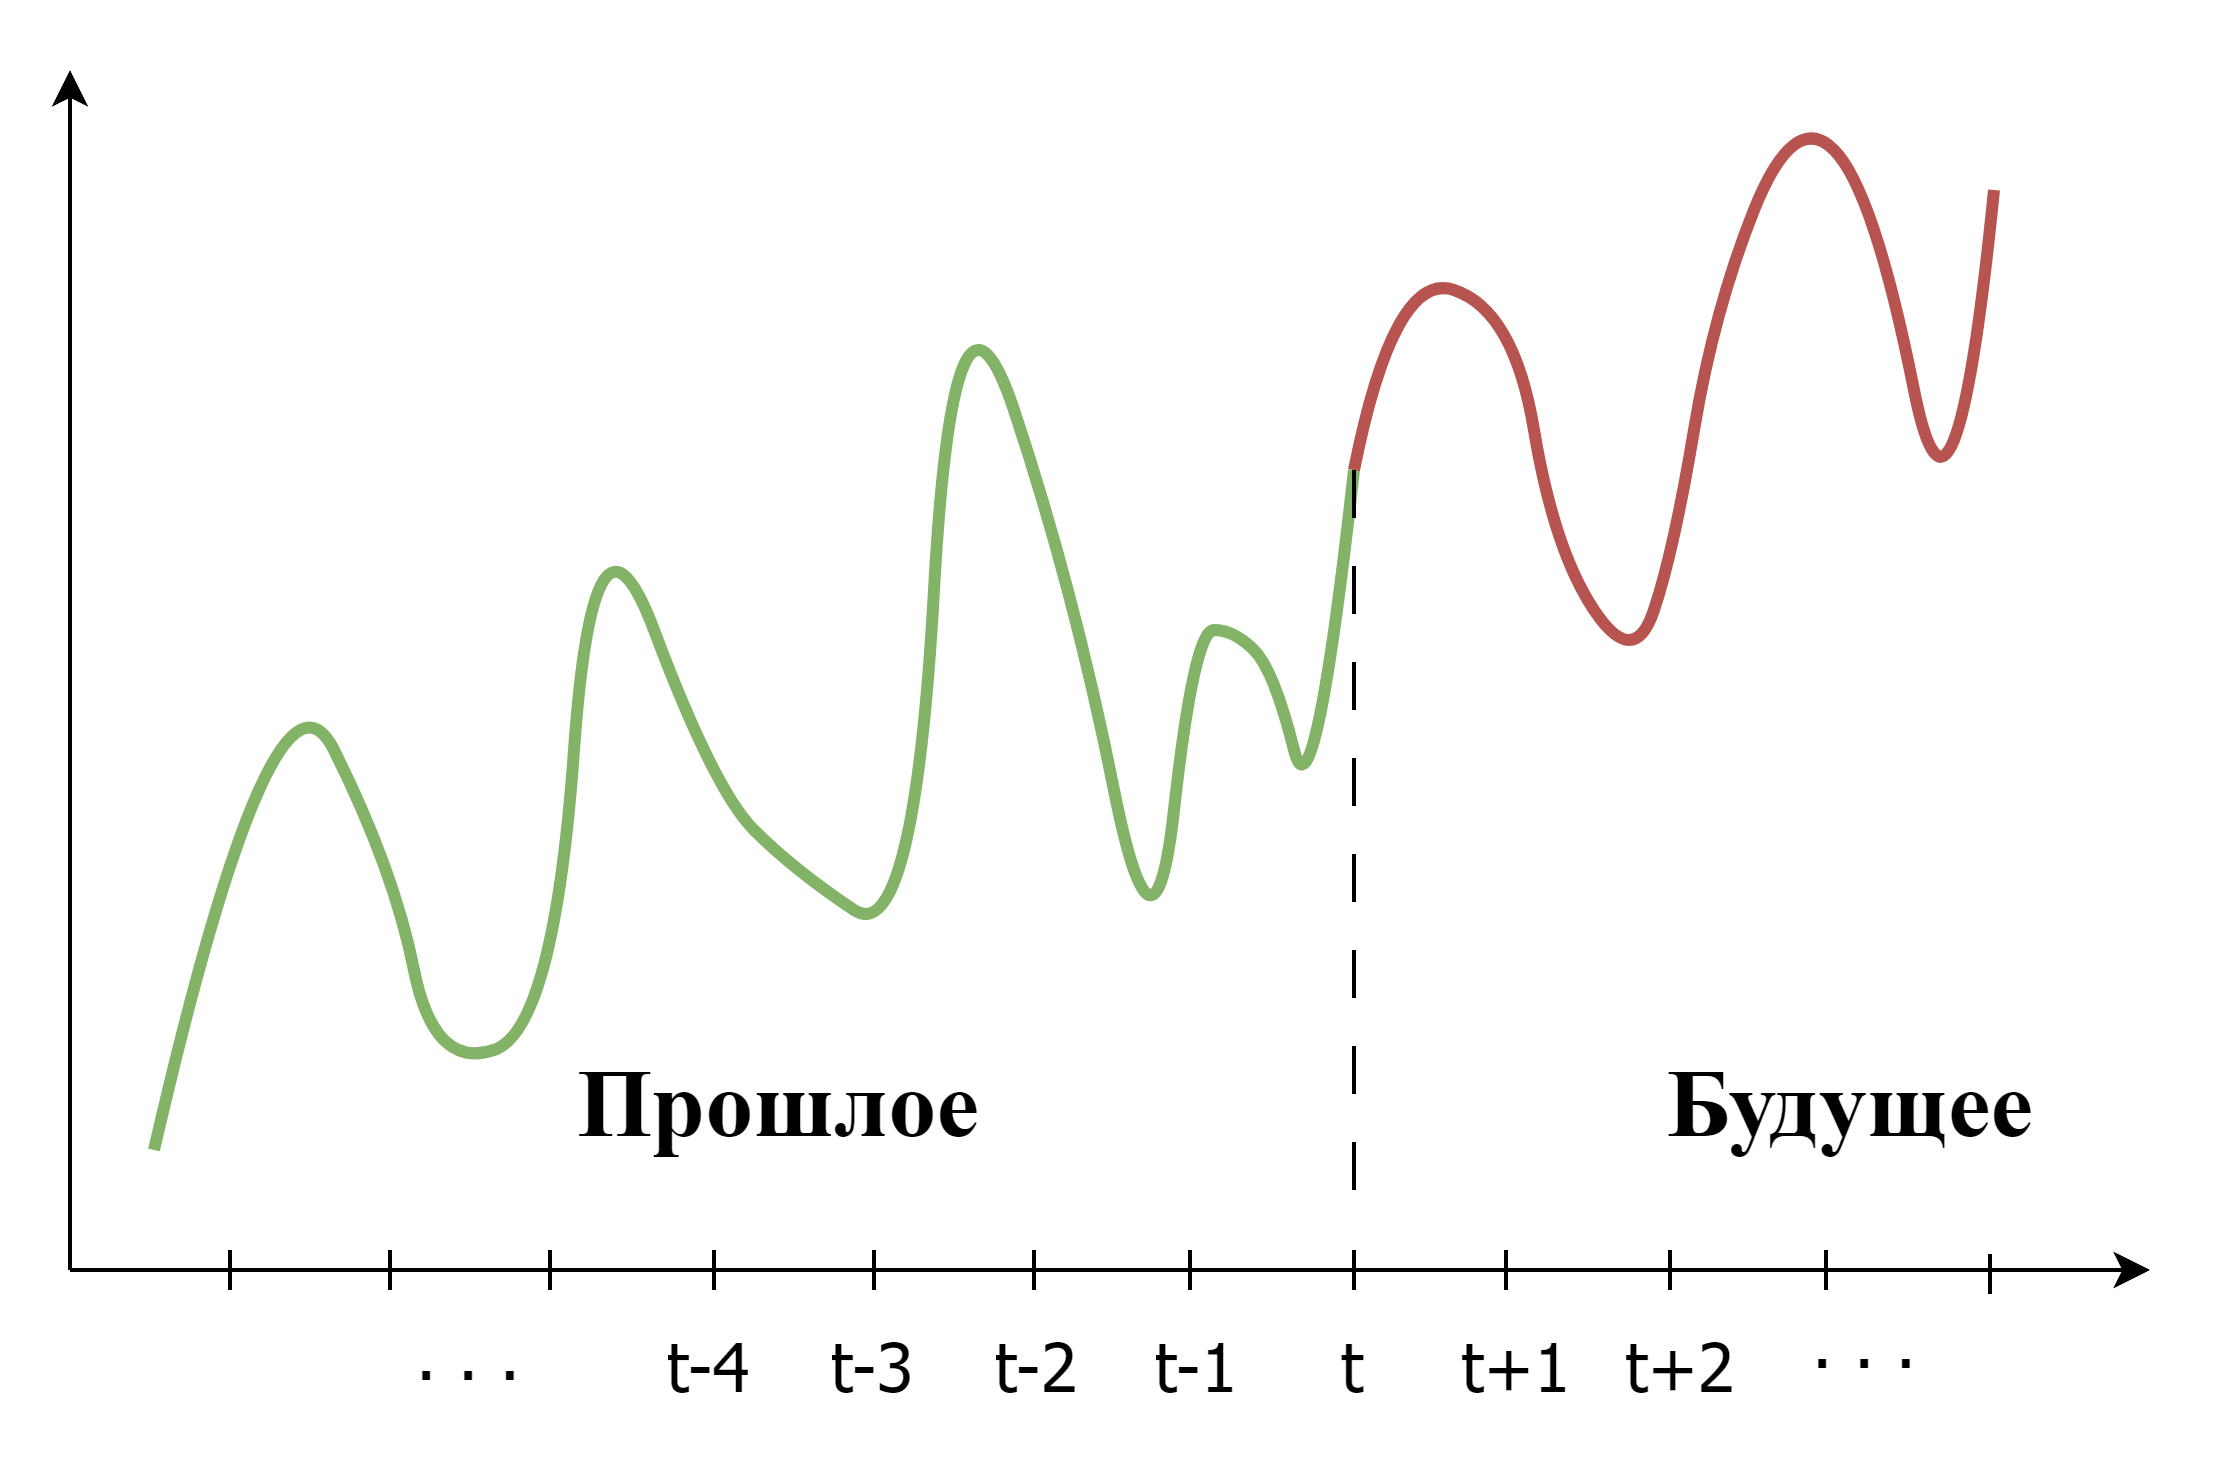

### Импорт библиотек и загрузка датасета

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

В качестве датасета мы возьмем биржевую сводку по дням акций компании Apple за период с 1 января 2014 года по 1 апреля 2024 года.

In [ ]:
# импортируем файл с данными о котировках
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

price = pd.read_csv("./AAPL.csv")
price.head()

--2024-04-03 07:59:59--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv.1’

AAPL.csv.1          100%[===================>] 182.17K   354KB/s    in 0.5s    

2024-04-03 08:00:00 (354 KB/s) - ‘AAPL.csv.1’ saved [186539/186539]



,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296652,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916719,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008968,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887323,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994270,258529600


Для анализа дневных котировок акций чаще всего используют столбец `Adj Close` (Adjusted closing price).

> **Adjusted closing price** — это цена закрытия, скорректированная с учётом корпоративных действий, таких как выплаты дивидендов, разделение акций или выпуск новых акций.

In [ ]:
close_price = pd.DataFrame(data=price, columns=['Date', 'Adj Close'])
close_price.head()

,Date,Adj Close
0,2014-01-02,17.296652
1,2014-01-03,16.916719
2,2014-01-06,17.008968
3,2014-01-07,16.887323
4,2014-01-08,16.994270


Сделаем дату индексом.

In [ ]:
# превратим дату в индекс и сделаем изменение постоянным
close_price.set_index('Date', inplace = True)
close_price.head()

,Adj Close
Date,
2014-01-02,17.296652
2014-01-03,16.916719
2014-01-06,17.008968
2014-01-07,16.887323
2014-01-08,16.994270


In [ ]:
# превратим дату (наш индекс) в объект datetime
close_price.index = pd.to_datetime(close_price.index)

# посмотрим на первые пять дат и на тип данных
close_price.index[:5]

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

Теперь мы можем делать срезы за определенный период, например, за первые 10 дней 2024 года. Как мы видим 1, 6 и 7 января, в праздничные и выходные дни, торгов не было.

In [ ]:
close_price['2024-01-01':'2024-01-10']

,Adj Close
Date,
2024-01-02,185.403412
2024-01-03,184.015198
2024-01-04,181.678177
2024-01-05,180.949097
2024-01-08,185.323517
2024-01-09,184.904053
2024-01-10,185.952713


**ВАЖНО**. Обратите внимание, что в отличие от списков, во временном ряде мы получаем данные и по начальной, и по конечной дате среза.

### Шаг временного ряда, сдвиг и скользящее среднее

При работе с временными рядами необходимо понимать как мы можем обобщать или изменять данные.

Например, мы можем изменить шаг нашего временного ряда с помощью метода `resample`, и посмотреть средние значения цен закрытия за год.

In [ ]:
close_price.resample(rule = 'AS').mean().head()

,Adj Close
Date,
2014-01-01,20.451843
2015-01-01,27.063668
2016-01-01,24.072507
2017-01-01,35.299758
2018-01-01,45.002878


В качестве шага можно использовать разные интервалы:
* `B`	- периодичность 1 рабочий день
* `D`	- периодичность 1 день
* `WS` - периодичность 1 начала недели
* `W`	- периодичность 1 конца недели
* `MS`	- периодичность 1 начала месяца
* `M`	- периодичность 1 конца месяца
* `QS`	- периодичность 1 начала квартала
* `Q`	- периодичность 1 конца квартала
* `AS`,	`YS` - периодичность 1 начала года
* `A`,	`Y`	- периодичность 1 конца года
* `H`,	`h`	- периодичность 1 час
* `T`,	`min`	- периодичность 1 минута
* `S`,	`s`	- периодичность 1 секунда
* `L`,	`ms`	- периодичность 1 миллисекунда
* `U`,	`us`	- периодичность 1 микросекунда
* `N`,	`ns`	- периодичность 1 наносекунда

Также можно использовать псевдонимы интервалов вместе с цифрами, например, для интервала сутки можно задать `24h`. Можно комбинировать и более сложные интервалы `2D20min15s` (2 дня 20 минут и 15 секунд).

Кроме того, мы можем сдвинуть (shift) наши данные на $n$ периодов вперед или назад. При этом, после сдвига первые два значения определяются как пропущенные значения (NaN или Not a number).

In [ ]:
close_price.shift(2).head()

,Adj Close
Date,
2014-01-02,NaN
2014-01-03,NaN
2014-01-06,17.296652
2014-01-07,16.916719
2014-01-08,17.008968


Другая полезная функция, которую мы можем применить к нашему временному ряду - это **скользящее среднее** (moving average, rolling average) за $n$ предыдущих периодов.

In [ ]:
# рассчитаем скользящее среднее для трех торговых дней
close_price.rolling(window = 3).mean().head()

,Adj Close
Date,
2014-01-02,NaN
2014-01-03,NaN
2014-01-06,17.074113
2014-01-07,16.937670
2014-01-08,16.963520


Период, за который рассчитывается скользящее среднее, называется окном (window), в нашем случае оно равно 3-м. Скользящее среднее - это всего лишь среднее значение от числа значений "попадающих в окно", т.е. для трех чисел: 2-х предыдущих и текущее значение.

Скользящее среднее можно получить достаточно просто с помощью среднего значения:

In [ ]:
window = 3
index = 4

print(f'Для даты {close_price.index[index]} скользящее среднее с окном {window}: {close_price[index-window+1:index+1]["Adj Close"].mean()}'  )

Для даты 2014-01-08 00:00:00 скользящее среднее с окном 3: 16.96352033333333


### Скользящее среднее на графике

Для построения простого графика временного ряда можно использовать встроенные в библиотеку Pandas инструменты:

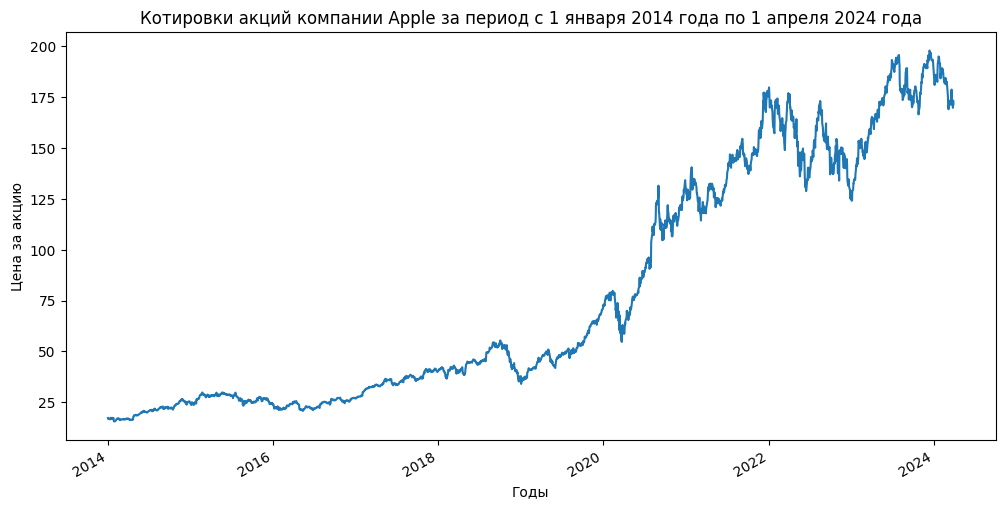

In [ ]:
# зададим размер графика, уберем легенду и добавим подписи
ax = close_price.plot(figsize = (12,6), legend = None)
ax.set(title = 'Котировки акций компании Apple за период с 1 января 2014 года по 1 апреля 2024 года', xlabel = 'Годы', ylabel = 'Цена за акцию')
print() # заглушка, чтобы не выводились значения от последнего метода


Однако, если нам надо построить на одном графике несколько кривых, то придется воспользоваться библиотекой Matplotlib. Давайте построим на одном графике котировки акций и скользящее среднее:

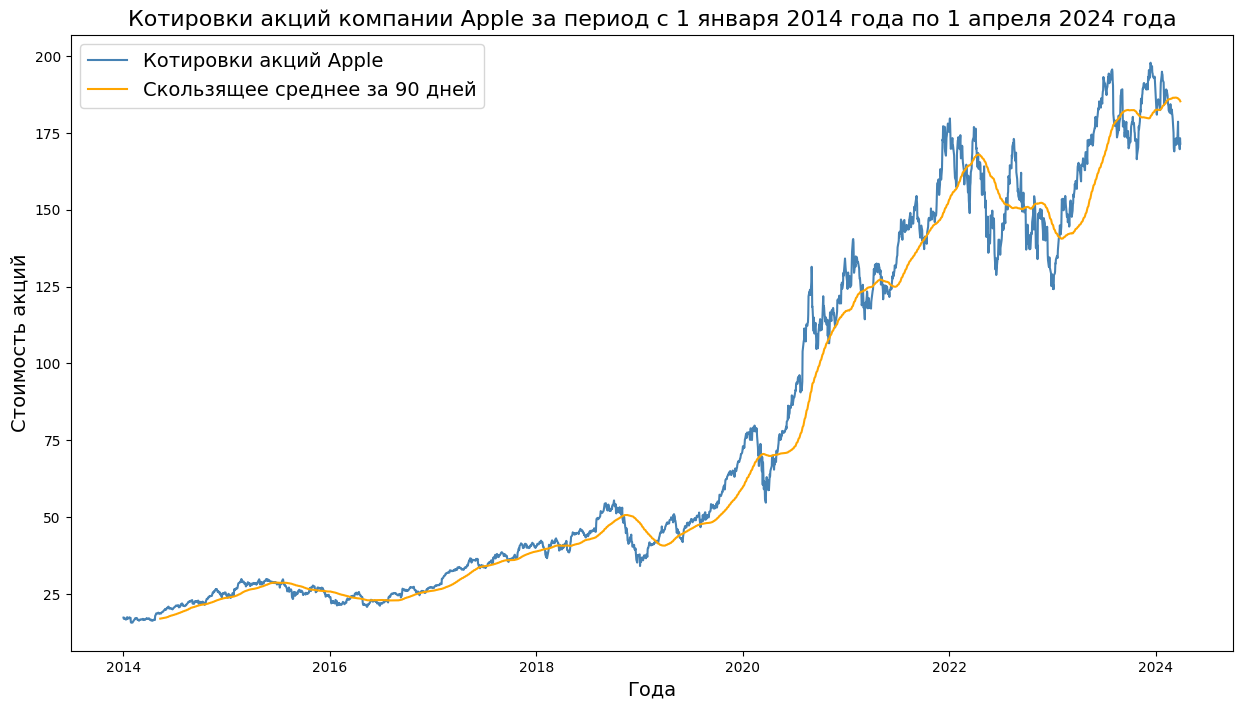

In [ ]:
# зададим размер графика
plt.figure(figsize = (15,8))

# зададим кривые стоимости акций и скользящее среднее на 90 дней
plt.plot(close_price, label = 'Котировки акций Apple', color = 'steelblue')
plt.plot(close_price.rolling(window = 90).mean(), label = 'Скользящее среднее за 90 дней', color = 'orange')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.xlabel('Года', fontsize = 14)
plt.ylabel('Стоимость акций', fontsize = 14)
plt.title('Котировки акций компании Apple за период с 1 января 2014 года по 1 апреля 2024 года', fontsize = 16)

# выведем обе кривые на одном графике
plt.show()

По графику видно, что скользящее среднее сильно сглаживает показатели. Так как мы применили окно в 90 дней, то и первое значение скользящего среднего смещается на 90 дней, однако надо понимать, что 90 дней в данном случае не равны календарным, а соответствуют торговым дням (когда проводились торги по акции). Реально график скользящее среднее начинается с `2014-05-12`:

In [ ]:
close_price.index[89] # 90-е значение в массиве, так как индекс начинается с 0

Timestamp('2014-05-12 00:00:00')

### Разложение временного ряда на компоненты

При работе с временными рядами важно уметь выявлять закономерности, для этого любой анализ временных рядов начинается с выделений компонент, а именно, разложение временного ряда на **тренд**, **сезонность**, **случайные колебания**.

Под **трендом** принято понимать долгосрочное, направленное (рост/падение/боковой тренд), изменение временного ряда.

Под **сезонностью** мы будем понимать циклическое изменение временного ряда с постоянным периодом.

**Случайные колебания** - непрогнозируемые случайные изменения временного ряда.

Для работы с компонентами  временных рядов в Python в модуле `statsmodels` есть функция `seasonal_decompose()`. Воспользуемся ей для визуализации компонентов ряда. Только есть один нюанс, если мы в нее передадим наш дата фрейм `close_price`, то получим ошибку. Данные необходимо передать в нее с равным шагом, именно для этого мы выше и рассматривали метод `resample`. Применим его с периодом в месяц.

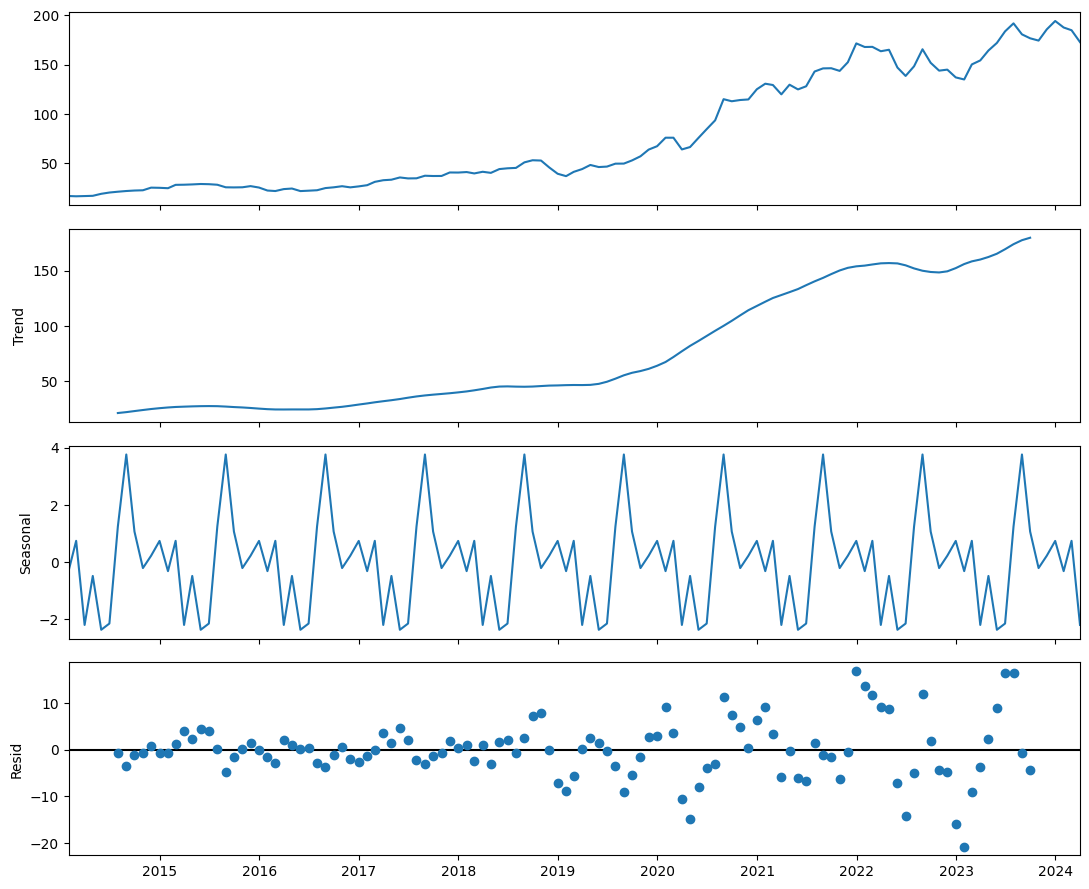

In [ ]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# применяем функцию к данным о котировках
decompose = seasonal_decompose(close_price.resample(rule = '1M').mean())
decompose.plot()

plt.show()

На графиках мы видим явно выроженный тренд (Trend) и сезонность (Seasonal). О чем это говорит?

Математики любят использовать умные слова и если тренд и сезонность отсутствуют, то говорят, что это стационарный временной ряд. И добавляют более страшную фразу: "среднее значение и дисперсия не меняются со смещением во времени". Но нам, нейронщикам, в это вникать не обязательно. Достаточно вызвать функцию, которую для нас написали математики и в зависимости от значения, которое она нам вернет, гордо заявить, что временной ряд стационарный или нет! Хотя и на глаз мы уже можем определять, если есть тренд с характерным направлением и сезонность проявляет периодичность на большом интервале (для многих задач наблюдается периодичность в 1 год).



> Стационарность или постоянство — свойство процесса не менять свои характеристики со временем.

Чтобы программно оценить стационарность применяют тест Дики-Фуллера.

In [ ]:
# импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

# передадим ей столбец 'Adj Close' с данными о котировках
adf_test = adfuller(close_price.resample(rule = '1M').mean()['Adj Close'])

# выведем форматированный результат теста
print(f'Мера изменчивости процесса: {adf_test[1]*100:.2f} %')

Мера изменчивости процесса: 96.28 %


Здесь мы чтобы не вникать в математику объявили результат теста мерой изменчивости процесса.


Мы не математики, а нейронщики, поэтому, не углубляясь в процесс, будем считать, что значение теста меньше 10% говорит нам о стационарном процессе, а все, что больше - разная степень нестационарности. Чем выше значение, тем временной ряд больше подвержен воздействию сезонности и тренда.

### Корреляция и автокорреляция

Автокорреляция позволяет выявлять тренд и сезонность, а поэтому нам придется ее разобрать, как полезный инструмент для анализа временных рядов.

Автокорреляция явно связана с корреляцией, это следует из названия.

**Корреляция** — это взаимосвязь между двумя переменными, при которой изменение одной из них сопровождается изменением другой. Здесь важно подчеркнуть слово «сопровождается», поскольку при корреляции эти изменения могут происходить без прямого влияния одной переменной на другую.

В ситуации же, когда такое прямое влияние доказано — можно говорить о **причинно-следственной связи**.

Пример корреляции может звучать так:
```
Рост потребления мороженого сопровождается ростом числа лесных пожаров.

```

У корреляции может быть несколько причин. Например, на две переменные влияет некий третий фактор, как в случае с ростом продаж мороженого и лесными пожарами. Этот фактор — теплое время года и высокая интенсивность солнечного излучения.

Но не всегда можно идентифицировать другие факторы, которые влияют на обе переменные, а иногда их может не быть вовсе. В таком случае уместно говорить о случайности.

Причинно-следственная связь всегда подразумевает наличие корреляции. Корреляция не обязательно означает наличие причинно-следственной связи. Корреляция может быть случайной, но причинно-следственная связь по определению не может быть случайностью.

Если корреляция есть, то для доказательства причинно-следственной связи должны соблюдаться еще два условия:

* Отсутствие сторонних факторов, которые влияют на обе переменные;
* Прямая временная последовательность между изменением первого и второго показателя, между событием A и событием B.

Хотя разница между корреляцией и причинно-следственной связью кажется очевидной, на практике принять одно за другое очень просто. И это всегда надо иметь ввиду.

Корреляция показывает силу взаимосвязи двух переменных. Степень взаимосвязи переменных можно измерить.
Для двух количественных переменных можно воспользоваться коэффициентом Пирсона. Диапазон значений этого коэффициента находится в пределах от минус единицы (отрицательная корреляция, если один показатель увеличивается, другой уменьшается и наоборот) до плюс единицы (положительная корреляция, если один увеличивается, другой тоже увеличивается и наоборот). Ноль означает отсутствие корреляции.


Возьмем умозрительный пример с мороженным и числом пожаров. Пусть мы пронаблюдали такие зависимости в течение года:

In [ ]:
# соберем данные о числе пожаров и потреблении мороженного (тысяч порций) в день
ice_cream = [148, 149, 149, 150, 151, 152, 152, 153, 153, 154, 155, 156, 157, 157, 158, 158, 159, 160, 161, 162, 163, 164, 165, 165, 166, 167, 167, 168, 168,  169, 170, 170, 171, 171, 171, 174, 175, 176, 177, 177, 178]
fire =       [291, 300, 301, 302, 304, 306, 308, 309, 310, 306, 307, 309, 310, 312, 313, 320, 314, 319, 324, 328, 328, 333, 336, 330, 339, 338, 350, 345, 347, 346, 342, 348, 355, 360, 362, 363, 366, 368, 368, 370, 385]


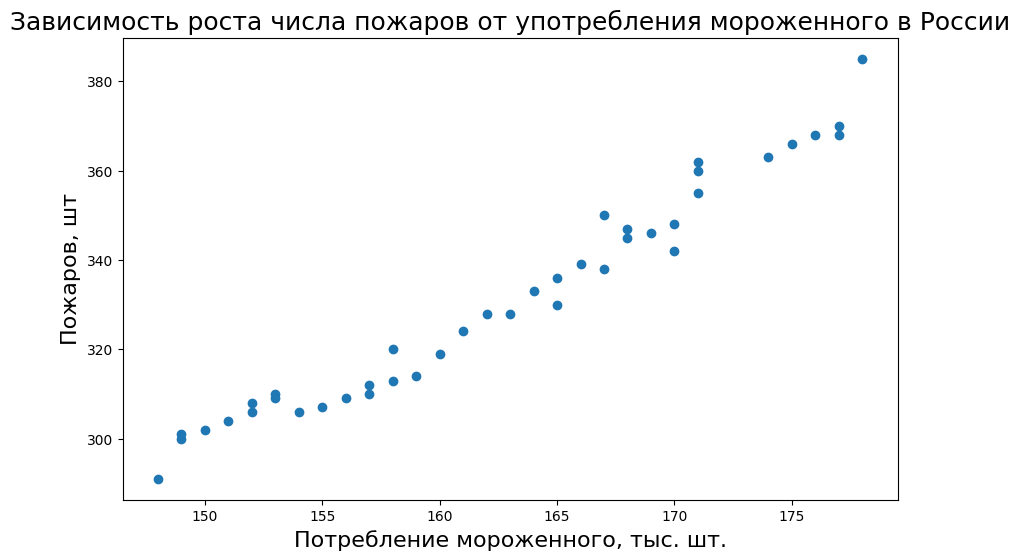

In [ ]:
# построим точечную диаграмму
plt.figure(figsize = (10,6))
plt.scatter(ice_cream, fire)

# добавим подписи
plt.xlabel('Потребление мороженного, тыс. шт.', fontsize = 16)
plt.ylabel('Пожаров, шт', fontsize = 16)
plt.title('Зависимость роста числа пожаров от употребления мороженного в России', fontsize = 18)
print() # Заглушка, чтобы не выводились данные от последней команда

Рассчитаем коэффициент корреляции с помощью библиотеки NumPy:



In [ ]:
# Используем NumPy
ice_cream_data = np.asarray(ice_cream) # Преобразуем list в массив NumPy

# посчитаем корреляцию с помощью матрицы корреляции
# так как мы получим корреляционную матрицу, возьмем первую строку и второй столбец [0, 1]
np.round(np.corrcoef(ice_cream, fire)[0, 1], 2) # округлим до 2-х знаков

0.98

Очень высокая, почти идеальная положительная корреляция между пожарами и потреблением мороженного. Однако говорить о причинно-следственной связи здесь бессмысленно. Даже корреляция равная единице или минус единице не означает наличие причинно-следственной связи.


Вернемся к автокорреляции. Автокорреляция также показывает степень взаимосвязи в диапазоне от –1 до 1, но только не двух переменных, а одной и той же переменной в разные моменты времени.


Так как нам надо часто вычислять коэффициент корреляции, то объявим функции и будем ее вызывать по мере необходимости:

In [ ]:
# Функция вычисления коэффициента автокорреляции

def get_corr_coef(
    data, # данные
    lag   # временной лаг
    ):

    array_data = np.asarray(data) # Преобразуем в массив NumPy

    # вычисление матрицы коэффициентов и отбор коэффициента из нужного места матрицы
    return np.corrcoef(array_data[lag:], array_data[:-lag])[0, 1]


Обратите внимание, что корреляционную матрицу мы строим по двум графикам: исходному и смещенному. Графики должны состоять из одинакового числа точек, а значит при сравнении мы исходный график обрезаем с конца на временной лаг.

Сместим наш график с потреблением мороженного на 5 временных лагов и найдем корреляцию:

In [ ]:
np.round(get_corr_coef(ice_cream, 5), 2)

0.99

Значение близкое к 1, говорит о сильном влиянии тренда. При обучении нейронных сетей наличие тренда будет мешать и нам придется от него избавляться. Так как обучая нейронную сеть на данных с трендом и сезонностью, мы ее учим всего лишь следовать за трендом и сезонностью. А наша задача выявить более глубокие закономерности при предсказании будущих значений нашего временного ряда.

**ВАЖНО**. Тренд может существенно исказить корреляционные показатели исходных данных. Его влияние тем хуже, чем больше величина элементов тренда по сравнению с величиной элементов исходного ряда. Сезонность стоит рассматривать тоже как периодический тренд, который искажает корреляционные показатели исходных данных.

### Избавляемся от тренда во временном ряду

Чтобы избавиться от тренда необходимо произвести вычитание текущего значения из следующего. Школьный курс математики, говорит нам о том, что такую процедуру осуществляет **дифференцирование данных**. Также если считать тренд линейной функцией от времени, то при дифференцировании по времени мы избавляемся от временной составляющей.  

Если мы продифференцируем наш ряд с потреблением мороженного, то увидим, что автокорреляция значительно снизится:

In [ ]:
np.round(get_corr_coef(np.diff(ice_cream), 5), 2)

0.21

Вернемся к нашему более сложному примеру с котировками акций и посмотрим на влияние тренда на автокорреляцию.




In [ ]:
np.round(get_corr_coef(close_price['Adj Close'], 5), 2)

1.0

При смещении графика на 5 лагов, мы получили с учетом округления сильную корреляцию равную 1, что подтверждает наличие тренда.

А теперь избавимся от тренда путем дифференцирования и посмотрим на автокорреляцию:

In [ ]:
np.round(get_corr_coef(np.diff(close_price['Adj Close']), 5), 2)

0.03

Теперь данные не коррелируют между собой.

Однако цифры не так информативны, как графики, поэтому за автокорреляцией удобно наблюдать и вычислять с помощью графика **автокорреляционной функции** (autocorrelation function, ACF).

Построим график ACF для котировок с учетом тренда:

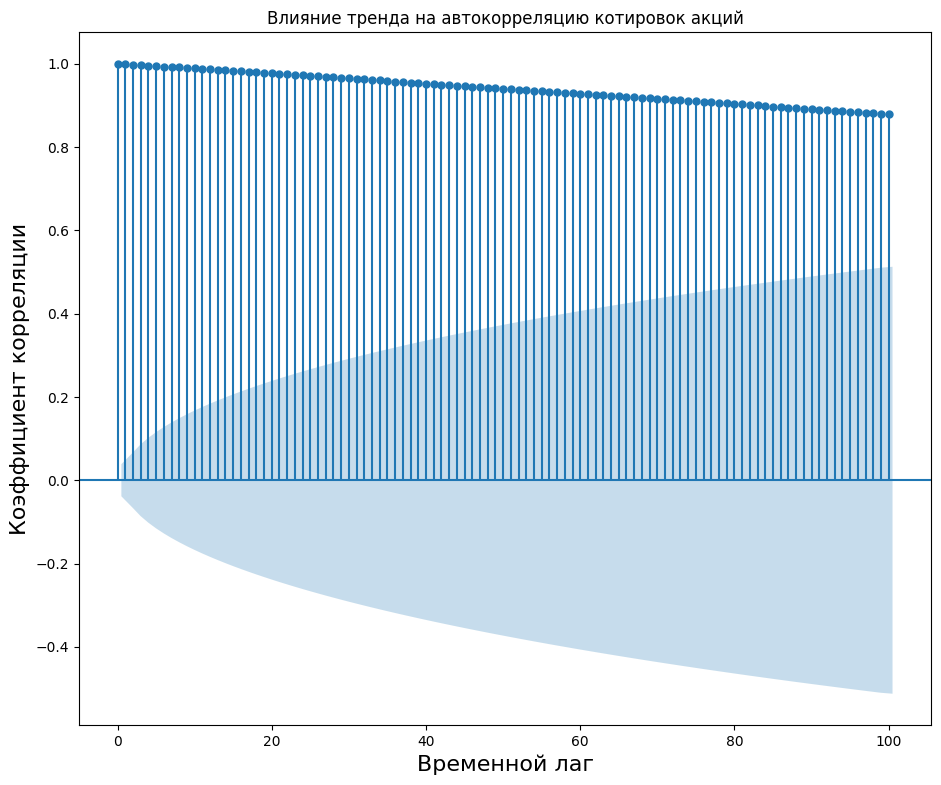

In [ ]:
# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

# применим функцию к нашему набору данных
# параметр lags - сколько мы хотим отобразить лагов
plot_acf(close_price['Adj Close'], lags = 100)

# добавим отступы сверху и снизу на графике
plt.axis('tight')
plt.title('Влияние тренда на автокорреляцию котировок акций')
plt.xlabel('Временной лаг', fontsize = 16)
plt.ylabel('Коэффициент корреляции', fontsize = 16)
plt.show()

Мы видим, что автокорреляция ряда с самим собой (первый столбец) равна 1 (временной лаг равен нулю), здесь все вполне логично.

То, что корреляция постоянно положительная, говорит о наличии тренда.
Также отметим, что синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна. Влияние тренда настолько сильно, что невозможно выявить из графика даже сезонности (при наличии сезонности на графике появляются периодические выбросы - пики).

Проведем дифференцирование и заново построим график автокорреляции:

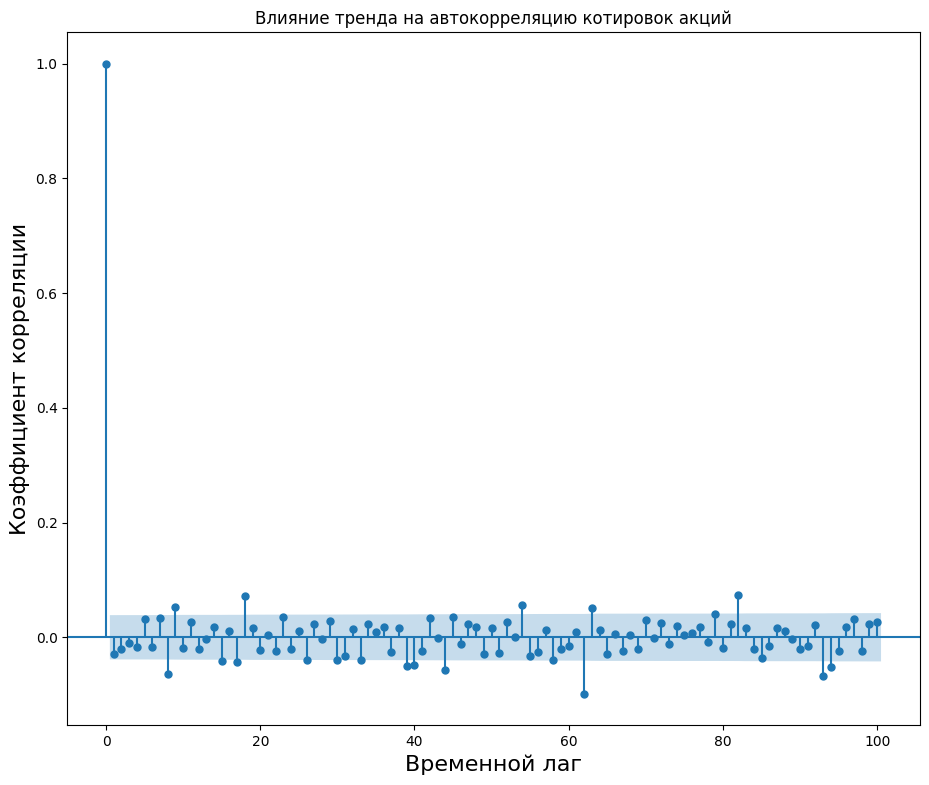

In [ ]:
# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

# применим функцию к нашему набору данных
# параметр lags - сколько мы хотим отобразить лагов
plot_acf(np.diff(close_price['Adj Close']), lags = 100)

# добавим отступы сверху и снизу на графике
plt.axis('tight')
plt.title('Автокорреляцию котировок акций после дифференцирования')
plt.xlabel('Временной лаг', fontsize = 16)
plt.ylabel('Коэффициент корреляции', fontsize = 16)
plt.show()

Важно отметить, что автокорреляция в данном случае намного слабее, мы не можем выявить четкой сезонности и тренда.

Теперь, когда мы разобрали основные методы анализа временных рядов, то пора переходить к [практическому](https://colab.research.google.com/drive/1-D-qXFYJ9b5sLLz_CFkUYmR-I2tM7KO2) применению нейронных сетей к временным рядам и провести сравнение архитектур.